# **Cataract detection using VGG19**





In [1]:
from google.colab import drive # Connecting Google Colab with Google Drive
drive.mount('/content/gdrive') #drive.mount is used to mount data which is present in drive

Mounted at /content/gdrive


In [2]:
!unzip /content/gdrive/MyDrive/Dataset/cataract_db.zip

Streaming output truncated to the last 5000 lines.
  inflating: preprocessed_images/2179_left.jpg  
  inflating: preprocessed_images/2179_right.jpg  
  inflating: preprocessed_images/217_left.jpg  
  inflating: preprocessed_images/217_right.jpg  
  inflating: preprocessed_images/2180_left.jpg  
  inflating: preprocessed_images/2180_right.jpg  
  inflating: preprocessed_images/2181_left.jpg  
  inflating: preprocessed_images/2181_right.jpg  
  inflating: preprocessed_images/2182_left.jpg  
  inflating: preprocessed_images/2182_right.jpg  
  inflating: preprocessed_images/2183_left.jpg  
  inflating: preprocessed_images/2183_right.jpg  
  inflating: preprocessed_images/2184_left.jpg  
  inflating: preprocessed_images/2184_right.jpg  
  inflating: preprocessed_images/2185_left.jpg  
  inflating: preprocessed_images/2185_right.jpg  
  inflating: preprocessed_images/2187_left.jpg  
  inflating: preprocessed_images/2187_right.jpg  
  inflating: preprocessed_images/2189_left.jpg  
  inflating

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("/content/full_df.csv")
df.head(5)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [5]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [6]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [7]:
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
left_cataract[:15]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
       '465_left.jpg', '477_left.jpg', '553_left.jpg', '560_left.jpg',
       '594_left.jpg', '611_left.jpg', '625_left.jpg'], dtype=object)

In [8]:
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:15]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg'], dtype=object)

In [9]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


In [10]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [11]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [12]:
print(len(cataract),len(normal))

594 500


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img,img_to_array

In [14]:
dataset_dir = "/content/preprocessed_images"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [15]:
import os

In [16]:
dataset = create_dataset(cataract,1)
len(dataset)

100%|██████████| 594/594 [00:03<00:00, 162.11it/s]


588

In [17]:
dataset = create_dataset(normal,0)
len(dataset)

100%|██████████| 500/500 [00:02<00:00, 245.16it/s]


1088

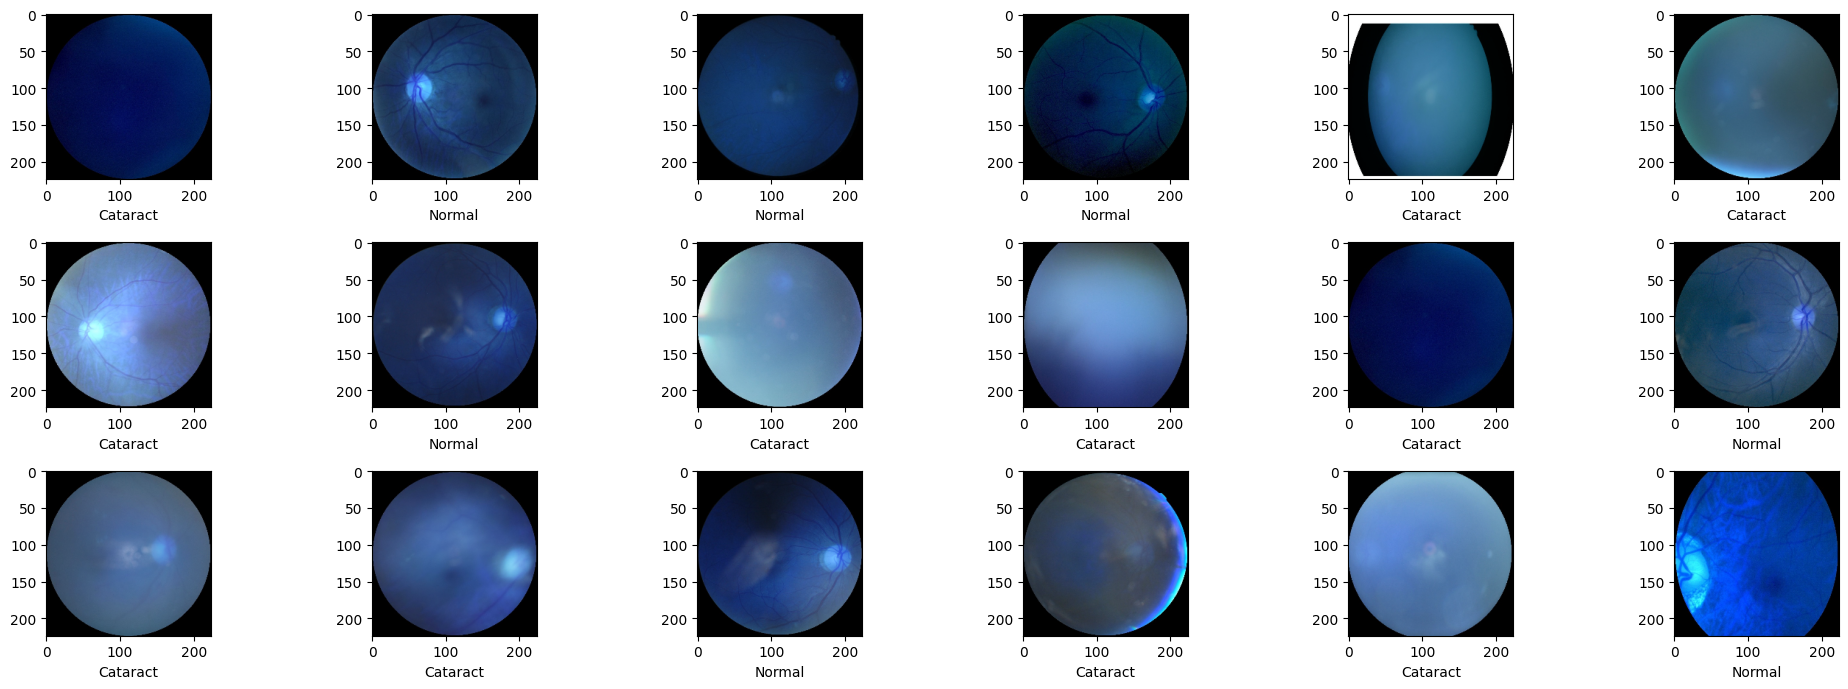

In [18]:
plt.figure(figsize=(20,7))
for i in range(18):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(3,6,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()   

In [19]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [20]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

80134624/80134624 [==============================] - 3s 0us/step


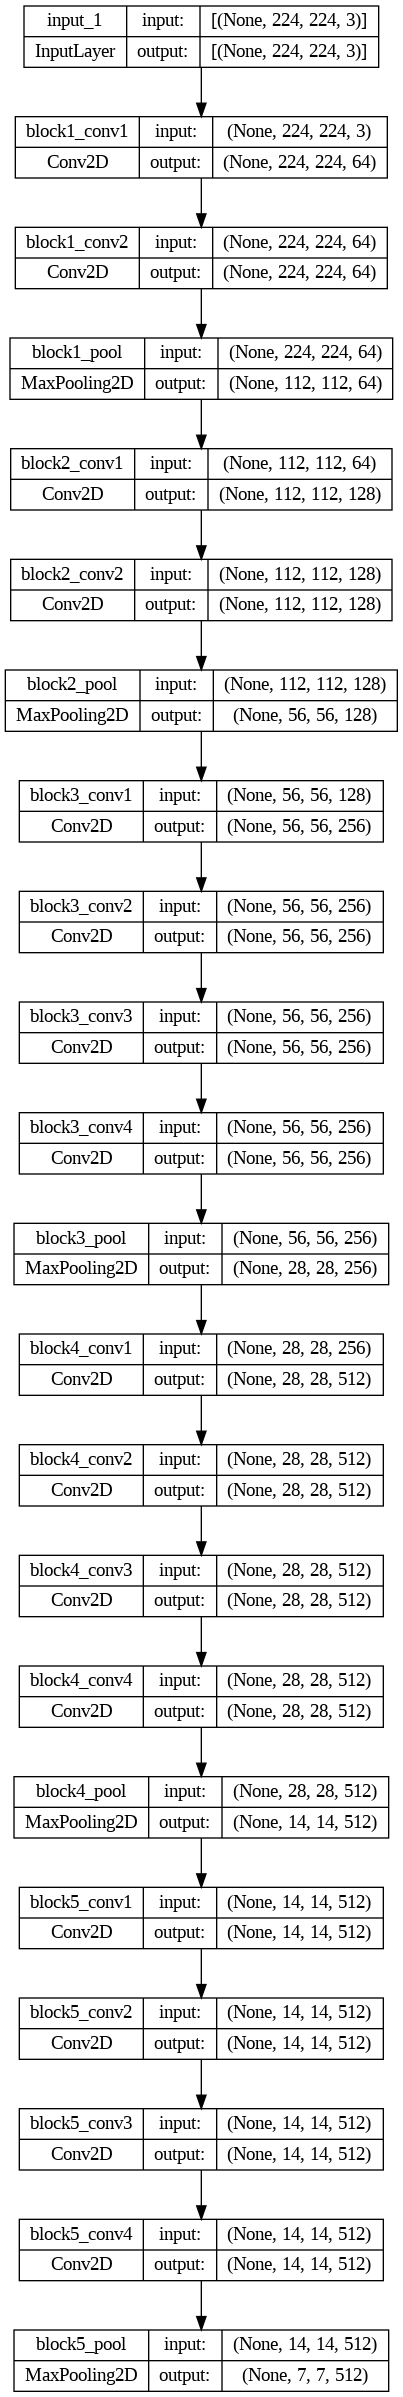

In [21]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

from tensorflow.keras.utils import plot_model
plot_model(vgg, to_file='VGG19Original.png', show_shapes=True, show_layer_names=True)

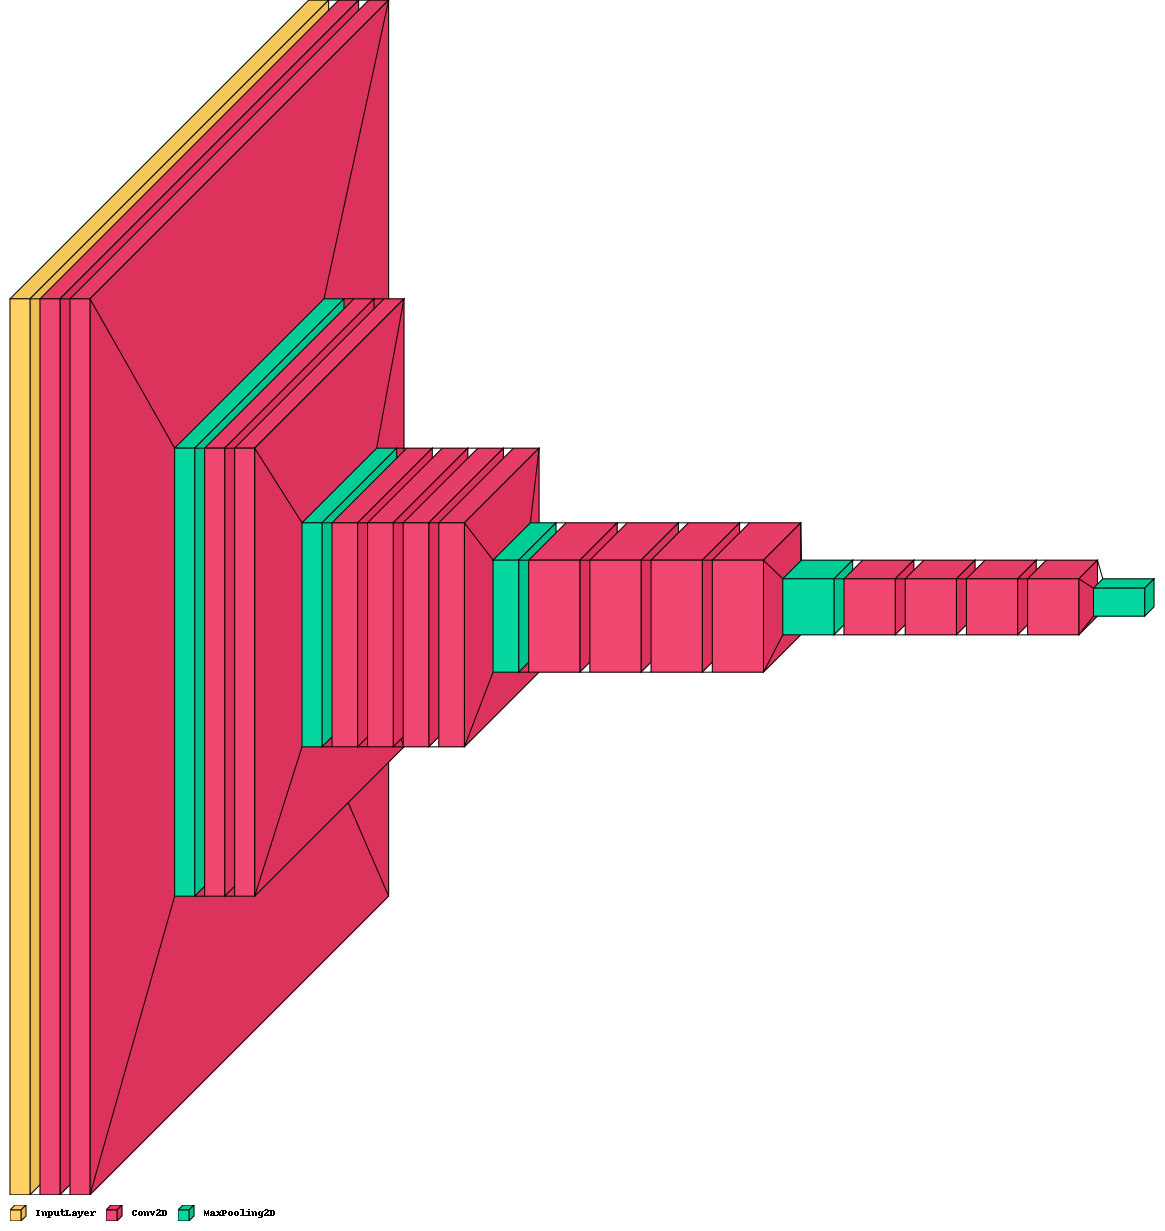

In [37]:
os.system('pip install visualkeras')
import visualkeras
visualkeras.layered_view(vgg, legend=True)

In [22]:
for layer in vgg.layers:
    layer.trainable = False

In [23]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


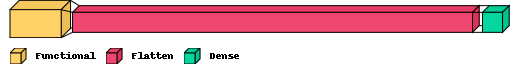

In [34]:
import os
os.system('pip install visualkeras')
import visualkeras
visualkeras.layered_view(model, legend=True)

In [25]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,save_weights_only=False)

earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [27]:
history = model.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/15
28/28 [==============================] - ETA: 0s - loss: 1.5071 - accuracy: 0.8931

28/28 [==============================] - 25s 392ms/step - loss: 1.5071 - accuracy: 0.8931 - val_loss: 0.6967 - val_accuracy: 0.9312
Epoch 2/15
27/28 [===========================>..] - ETA: 0s - loss: 0.2098 - accuracy: 0.9711

28/28 [==============================] - 5s 190ms/step - loss: 0.2145 - accuracy: 0.9701 - val_loss: 0.4388 - val_accuracy: 0.9587
Epoch 3/15
28/28 [==============================] - ETA: 0s - loss: 0.1354 - accuracy: 0.9770

28/28 [==============================] - 5s 196ms/step - loss: 0.1354 - accuracy: 0.9770 - val_loss: 0.6505 - val_accuracy: 0.9495
Epoch 4/15
28/28 [==============================] - ETA: 0s - loss: 0.0607 - accuracy: 0.9885

28/28 [==============================] - 5s 195ms/step - loss: 0.0607 - accuracy: 0.9885 - val_loss: 0.5572 - val_accuracy: 0.9633
Epoch 5/15
28/28 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.9977

28/28 [==============================] - 5s 189ms/step - loss: 0.0095 - accuracy: 0.9977 - val_loss: 0.5066 - val_accuracy: 0.9633
Epoch 6/15
28/28 [==============================] - ETA: 0s - loss: 0.0075 - accuracy: 0.9943

28/28 [==============================] - 5s 189ms/step - loss: 0.0075 - accuracy: 0.9943 - val_loss: 0.5325 - val_accuracy: 0.9679
Epoch 7/15
28/28 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 0.9977

28/28 [==============================] - 5s 190ms/step - loss: 0.0067 - accuracy: 0.9977 - val_loss: 0.5085 - val_accuracy: 0.9679
Epoch 8/15
28/28 [==============================] - ETA: 0s - loss: 0.0074 - accuracy: 0.9977

28/28 [==============================] - 5s 197ms/step - loss: 0.0074 - accuracy: 0.9977 - val_loss: 0.5616 - val_accuracy: 0.9541
Epoch 9/15
28/28 [==============================] - ETA: 0s - loss: 7.0489e-04 - accuracy: 1.0000

28/28 [==============================] - 6s 205ms/step - loss: 7.0489e-04 - accuracy: 1.0000 - val_loss: 0.5218 - val_accuracy: 0.9679
Epoch 10/15
28/28 [==============================] - ETA: 0s - loss: 5.3748e-05 - accuracy: 1.0000

28/28 [==============================] - 6s 207ms/step - loss: 5.3748e-05 - accuracy: 1.0000 - val_loss: 0.5132 - val_accuracy: 0.9679
Epoch 11/15
28/28 [==============================] - ETA: 0s - loss: 2.3463e-05 - accuracy: 1.0000

28/28 [==============================] - 6s 209ms/step - loss: 2.3463e-05 - accuracy: 1.0000 - val_loss: 0.5129 - val_accuracy: 0.9679
Epoch 12/15
28/28 [==============================] - ETA: 0s - loss: 2.1717e-05 - accuracy: 1.0000

28/28 [==============================] - 6s 209ms/step - loss: 2.1717e-05 - accuracy: 1.0000 - val_loss: 0.5115 - val_accuracy: 0.9679
Epoch 13/15
28/28 [==============================] - ETA: 0s - loss: 2.0355e-05 - accuracy: 1.0000

28/28 [==============================] - 6s 207ms/step - loss: 2.0355e-05 - accuracy: 1.0000 - val_loss: 0.5104 - val_accuracy: 0.9679
Epoch 14/15
28/28 [==============================] - ETA: 0s - loss: 1.9264e-05 - accuracy: 1.0000

28/28 [==============================] - 6s 213ms/step - loss: 1.9264e-05 - accuracy: 1.0000 - val_loss: 0.5095 - val_accuracy: 0.9679
Epoch 15/15
28/28 [==============================] - ETA: 0s - loss: 1.8256e-05 - accuracy: 1.0000

28/28 [==============================] - 6s 214ms/step - loss: 1.8256e-05 - accuracy: 1.0000 - val_loss: 0.5085 - val_accuracy: 0.9679


In [28]:
print("Trainning Evaluation")
loss,accuracy = model.evaluate(x_train,y_train)
print("loss:",loss)
print("Accuracy:",accuracy)

print("Testing Evaluation")
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

Trainning Evaluation
28/28 [==============================] - 5s 166ms/step - loss: 1.7516e-05 - accuracy: 1.0000
loss: 1.7515543731860816e-05
Accuracy: 1.0
Testing Evaluation
7/7 [==============================] - 1s 172ms/step - loss: 0.5085 - accuracy: 0.9679
loss: 0.5084801316261292
Accuracy: 0.9678899049758911


Text(0.5, 1.0, 'Loss Evolution')

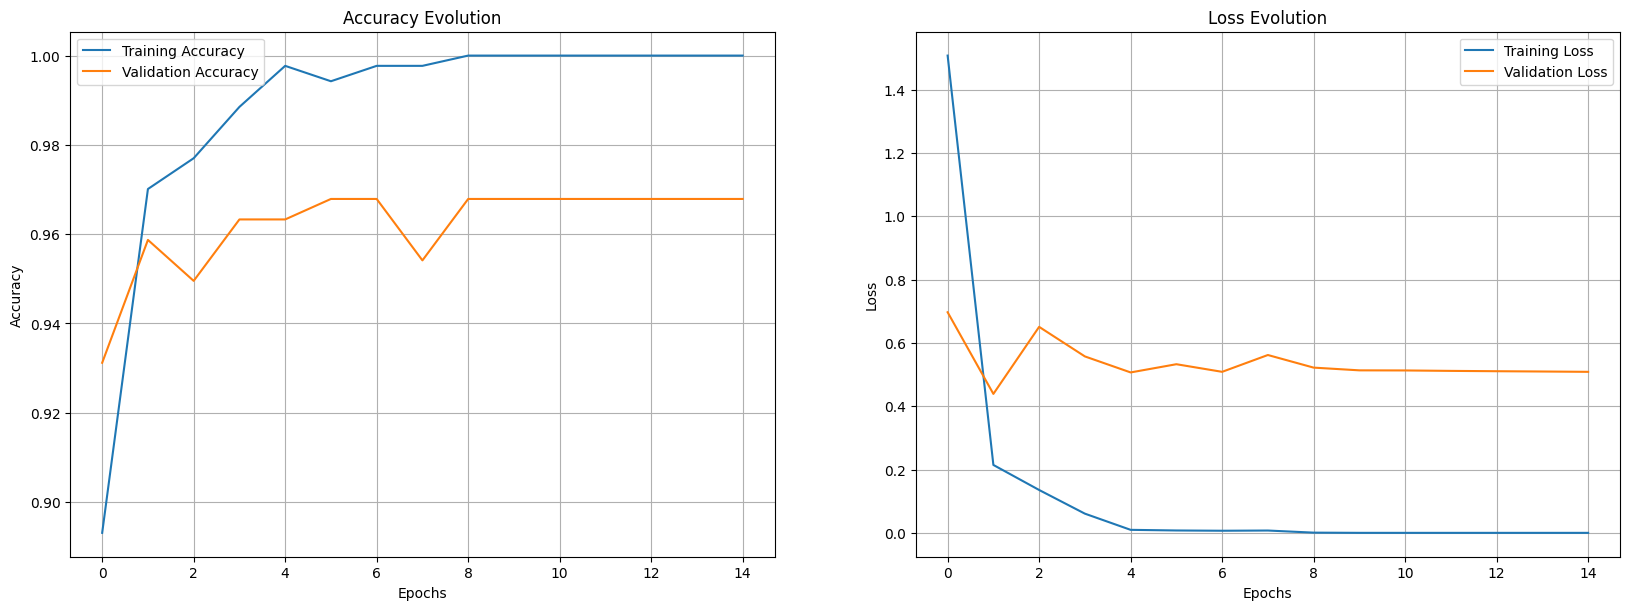

In [29]:
plt.figure(figsize=(20, 15))

#Model Accuracy
plt.subplot(2,2,1)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot( history.history["accuracy"], label = "Training Accuracy")
plt.plot( history.history["val_accuracy"], label = "Validation Accuracy")
plt.grid(True)
plt.legend()
plt.title('Accuracy Evolution')

#Model Loss
plt.subplot(2, 2, 2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.grid(True)
plt.legend()
plt.title('Loss Evolution')

In [30]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

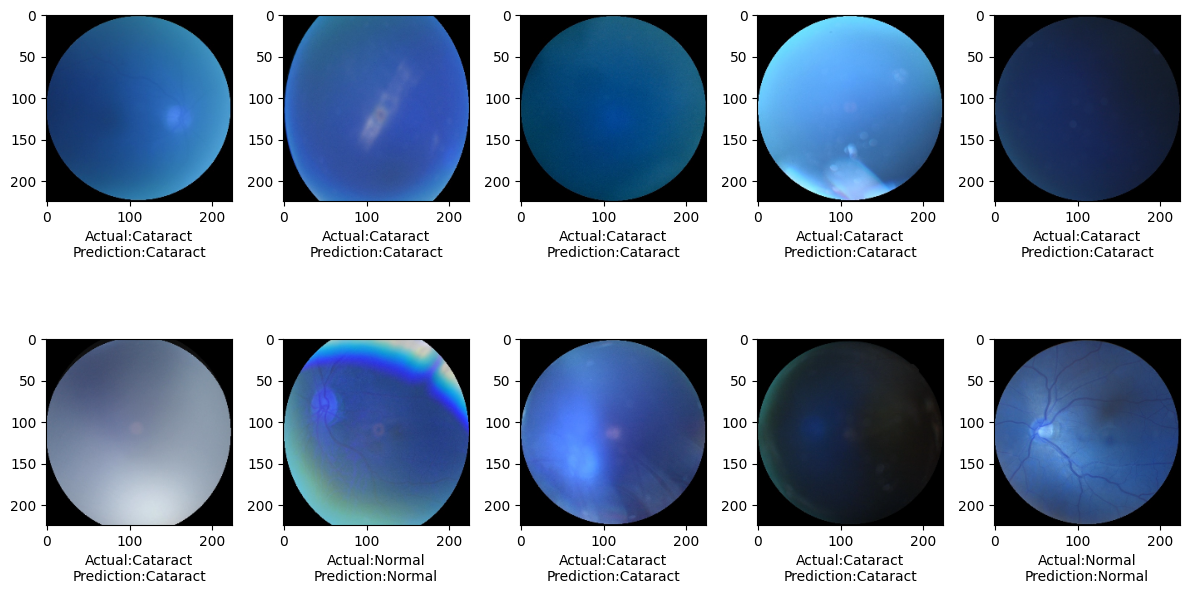

In [33]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_test[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 